### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 4. Handling Class Imbalance

Lale has scikit-learn compatible wrappers for a subset of the operators from [imbalanced-learn](https://imbalanced-learn.org). This notebook demonstrates how to use them for a classification task.

This tutorial has following sections:

-   [4.1 Dataset](#dataset)
-	[4.2 A Classification Pipeline without Imbalance Correction](#withoutcorrection)
-	[4.3 Over-sampling using SMOTE](#oversampling)
-	[4.4 Under-sampling using CondensedNearestNeighbour](#undersampling)
-	[4.5 Combined over and under sampling using SMOTEENN](#combined)
-	[4.6 AutoML with Imbalance Correction](#automl)
-	[4.7 Summary](#summary)

<a id="dataset"></a>
## 4.1 Dataset

This demonstration uses the [credit-g](https://www.openml.org/d/31) dataset from OpenML.

In [1]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)

Next, let's look at the class distribution.

<AxesSubplot:>

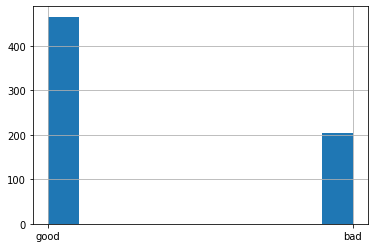

In [2]:
train_y.hist()

As can be seen, we have more than twice the examples with class label `good` than `bad`, making `credit-g` a good candidate for experimenting with class imbalance correction.

<a id="withoutcorrection"></a>
## 4.2 A Classification Pipeline without Imbalance Correction

We first try to use a simple classification pipeline without any attempt at correcting the class imbalance.

The pipeline encodes categorical columns and applies min-max scaling to the numerical columns and then uses a RandomForestClassifier for classification. The next cell assumes understanding of Lale's pipeline structure, please look at the notebook [Customizing Algorithm Choices and Hyperparameters](./03_custom.ipynb) if you are not familiar with it yet.

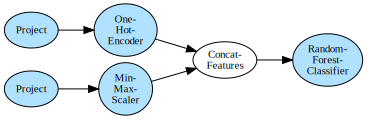

In [3]:
from lale.lib.lale import Project, ConcatFeatures
from lale.lib.sklearn import OneHotEncoder, MinMaxScaler, RandomForestClassifier

cat_enc = Project(columns={"type": "string"}) >> OneHotEncoder(handle_unknown="ignore")
num = Project(columns={"type": "number"}) >> MinMaxScaler()
prefix = (cat_enc & num) >> ConcatFeatures()

pipeline_without_correction = prefix >> RandomForestClassifier()
pipeline_without_correction.visualize()

In [4]:
trained_pipeline = pipeline_without_correction.fit(train_X, train_y)
predictions = trained_pipeline.predict(test_X)

We evaluate the pipeline using multiple classification metrics as class imbalance can manifest in one or more of them.

In [5]:
def classification_metrics(test_y, predictions):
    from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
    from imblearn.metrics import geometric_mean_score

    print(f"accuracy: {accuracy_score(test_y, predictions):.3f}")
    print(f"f1-score: {f1_score(test_y, predictions, pos_label='good'):.3f}")
    print(f"balanced accuracy: {balanced_accuracy_score(test_y, predictions):.3f}")
    print(f"geometric mean: {geometric_mean_score(test_y, predictions):.3f}")
    
classification_metrics(test_y, predictions)

accuracy: 0.788
f1-score: 0.859
balanced accuracy: 0.697
geometric mean: 0.662


<a id="oversampling"></a>
## 4.3 Over-sampling using SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is a popular over-sampling technique to handle class imbalance. Lale has an operator [lale.lib.imblearn.SMOTE](https://lale.readthedocs.io/en/latest/modules/lale.lib.imblearn.smote.html) which wraps the SMOTE implementation from [imbalanced-learn](https://imbalanced-learn.org).

Note that over-sampling changes the number of samples used for training, and it should not be applied during predict. The SMOTE Lale operator takes care of this during `fit` and `predict`. It is implemented as a *higher-order operator* which means that it allows another Lale single operator or pipeline to be passed to it as a hyperparameter operator. SMOTE will then over-sample the training data and pass it to the nested operator during `fit`. 

For our example, we use the preprocessing prefix that we created in the previous section and apply over-sampling to RandomForestClassifier. Some of the preprocessing such as encoding of categoricals is required before applying SMOTE as it relies on a distance metric computation that expects numeric features.

Since SMOTE is a Lale operator, it can also participate in AutoML and the search space will include its hyperparameters as well as the nested operator's hyperparameters as applicable. [Section 4.6](#automl) will demonstrate this.

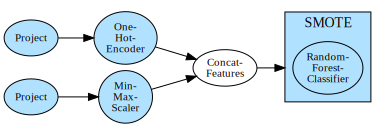

In [6]:
from lale.lib.imblearn import SMOTE

pipeline_with_correction =  prefix >> SMOTE(operator = RandomForestClassifier(), k_neighbors=12)
pipeline_with_correction.visualize()

In [7]:
trained_pipeline = pipeline_with_correction.fit(train_X, train_y)
predictions = trained_pipeline.predict(test_X)

In [8]:
classification_metrics(test_y, predictions)

accuracy: 0.764
f1-score: 0.836
balanced accuracy: 0.701
geometric mean: 0.685


<a id="undersampling"></a>
## 4.4 Under-sampling using CondensedNearestNeighbour

One of the techniques for class imbalance correction is under-sampling. There are several methods for under-sampling. Here, we illustrate [lale.lib.imblearn.CondensedNearestNeighbour](https://lale.readthedocs.io/en/latest/modules/lale.lib.imblearn.condensed_nearest_neighbour.html). It has a usage pattern similar to `SMOTE`.

In [9]:
from lale.lib.imblearn import CondensedNearestNeighbour

pipeline_with_correction =  prefix >> CondensedNearestNeighbour(operator = RandomForestClassifier())
trained_pipeline = pipeline_with_correction.fit(train_X, train_y)
predictions = trained_pipeline.predict(test_X)

In [10]:
classification_metrics(test_y, predictions)

accuracy: 0.691
f1-score: 0.757
balanced accuracy: 0.699
geometric mean: 0.699


<a id="combined"></a>
## 4.5 Combined over and under sampling using SMOTEENN

Some of the imbalance correction methods combine over-sampling and under-sampling. `SMOTEENN` is one of those which performs over-sampling using `SMOTE` followed by under-sampling using Edited Nearest Neighbours (`ENN`).
The following code sample illustrates the usage of [lale.lib.imblearn.SMOTEENN](https://lale.readthedocs.io/en/latest/modules/lale.lib.imblearn.smoteenn.html) on `credit-g` and its evaluation.

In [11]:
from lale.lib.imblearn import SMOTEENN

pipeline_with_correction =  prefix >> SMOTEENN(operator = RandomForestClassifier())
trained_pipeline = pipeline_with_correction.fit(train_X, train_y)
predictions = trained_pipeline.predict(test_X)

In [12]:
classification_metrics(test_y, predictions)

accuracy: 0.648
f1-score: 0.713
balanced accuracy: 0.672
geometric mean: 0.670


<a id="automl"></a>
## 4.6 AutoML with Imbalance Correction

As mentioned earlier, the operators from `lale.lib.imblearn` are `higher-order operators`. They can be used as individual operators or in a pipeline. The nested `operator` hyperparameter to those is also a Lale operator. This allows AutoML search to include the hyperparameter search space of the outer operator as well as the nested operator. The following example uses our previous examples of `SMOTE` and `SMOTEENN` for imbalance correction. For `SMOTE`, it tries a choice between `RandomForestClassifier` and `XGBClassifier`. `Hyperopt` is used as the optimizer to select between the choices and tune hyperparameters of the entire pipeline.

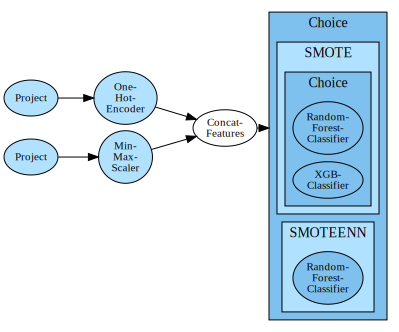

In [13]:
from lale.lib.lale import Hyperopt
from lale.lib.xgboost import XGBClassifier

pipeline_with_correction =  prefix >> (SMOTE(operator = RandomForestClassifier | XGBClassifier)
                                       | SMOTEENN(operator = RandomForestClassifier))
pipeline_with_correction.visualize()

100%|████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/trial, best loss: -0.7052999549644514]


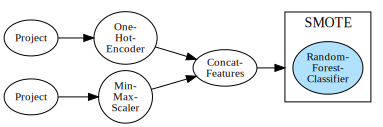

In [14]:
trained_pipeline = pipeline_with_correction.auto_configure(train_X, train_y, 
                                                           optimizer=Hyperopt, 
                                                           max_evals=10, 
                                                           cv=5, 
                                                           scoring='balanced_accuracy')
predictions = trained_pipeline.predict(test_X)
trained_pipeline.visualize()

In [15]:
classification_metrics(test_y, predictions)

accuracy: 0.682
f1-score: 0.752
balanced accuracy: 0.683
geometric mean: 0.683


<a id="summary"></a>
## 4.7 Summary

In this tutorial, we illustrated how to use operators from [lale.lib.imblearn](https://lale.readthedocs.io/en/latest/modules/lale.lib.imblearn.html#module-lale.lib.imblearn) for class imbalance correction for manual machine learning as well as AutoML. From the experiments, it can be seen that the effect of such correction varies across different performance metrics. Using them seamlessly with AutoML can help find the best correction technique as well as its hyperparameters.